# Mach-Zehnder interferometers

The basic concept behind a Mach-Zehnder interferometer is that it splits a beam of light into two path and then recombines them. The resulting interference pattern depends on the relative phase of the two paths. This is a very common device in quantum optics, and is used in many experiments.

Phase shifts may be caused by differing path lengths, or by the application of a phase shifter, such as a piezo-electric transducer.

# Designing a Mach-Zehnder interferometer
![Image of a MZI](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/mzi_outline_ports_marked.webp)

The above image shows a Mach-Zehnder interferometer. The input port is the top grating coupler and the output port is the bottom grating coupler. This particular design utilizes a path length difference to introduce a relative phase difference between the two paths. 

Simphony is an opensource photonic circuit simulator that already has a grating coupler model, y-branches, and waveguides which can be used to implement a Mach-Zehnder interferometer. The following code block was taken from the Simphony github and shows how to create a Mach-Zehnder interferometer using Simphony. To learn how to set up your own simulations in Simphony, see the official [Simphony documentation](https://simphonyphotonics.readthedocs.io/en/latest/index.html) 

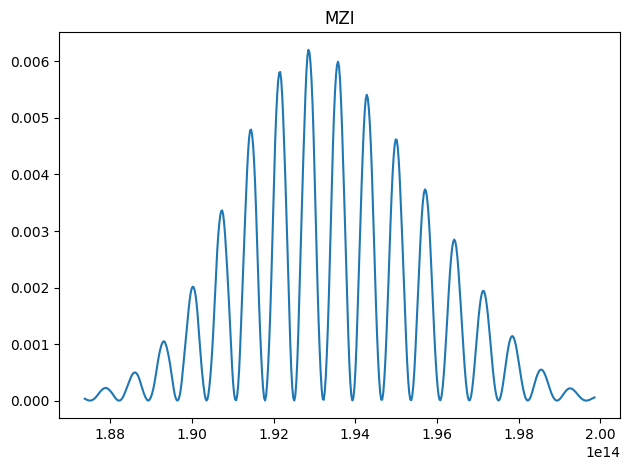

In [4]:
# Copyright © Simphony Project Contributors
# Licensed under the terms of the MIT License
# (see simphony/__init__.py for details)

import matplotlib.pyplot as plt

from simphony.libraries import siepic
from simphony.simulation import Detector, Laser, Simulation

# first we initialize all of the components in the MZI circuit
gc_input = siepic.GratingCoupler()
y_splitter = siepic.YBranch()
wg_long = siepic.Waveguide(length=150e-6)
wg_short = siepic.Waveguide(length=50e-6)
y_recombiner = siepic.YBranch()
gc_output = siepic.GratingCoupler()

# next we connect the components to each other
# you can connect pins directly:
y_splitter["pin1"].connect(gc_input["pin1"])

# or connect components with components:
# (when using components to make connections, their first unconnected pin will
# be used to make the connection.)
y_splitter.connect(wg_long)

# or any combination of the two:
y_splitter["pin3"].connect(wg_short)
# y_splitter.connect(wg_short["pin1"])

# when making multiple connections, it is often simpler to use `multiconnect`
# multiconnect accepts components, pins, and None
# if None is passed in, the corresponding pin is skipped
y_recombiner.multiconnect(gc_output, wg_short, wg_long)

# do a simple sweep simulation
theoretical = None
with Simulation() as sim:
    l = Laser(power=20e-3)
    l.wlsweep(1500e-9, 1600e-9)
    l.connect(gc_input)
    Detector().connect(gc_output)

    theoretical = sim.sample()

plt.plot(sim.freqs, theoretical[:, 0, 0])
plt.title("MZI")
plt.tight_layout()
plt.show()

# if we specify multiple samples, noise gets added to the simulation
with Simulation() as sim:
    l = Laser(power=20e-3)
    l.wlsweep(1500e-9, 1600e-9)
    l.connect(gc_input)
    Detector().connect(gc_output)

    # we get 101 samples even though we only use 3 because
    # filtering requires at least 21 samples and the results
    # get better with more samples and 101 isn't much slower
    # than 21
    noisy = sim.sample(101)

As you can see, and as you might have predicted, by varying the wavelength we can see different levels of power being output from the device. Notice how the power periodically dips to 0. This occurs when the phases of the two paths are exactly opposite, and the light destructively interferes. The power, however does not peak at a consistent maximum, since the mach-zhender has been optimized for a particular wavelength.

Monte Carlo Run 0
Monte Carlo Run 1
Monte Carlo Run 2
Monte Carlo Run 3
Monte Carlo Run 4
Monte Carlo Run 5
Monte Carlo Run 6
Monte Carlo Run 7
Monte Carlo Run 8
Monte Carlo Run 9


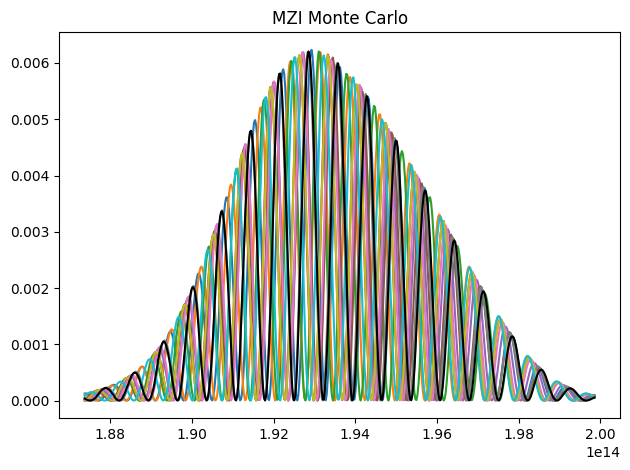

## Sweeping
Imagine we shined a laser into the first grating coupler and then adjusted the wavelength over some range. We then can plot the data from the intensity of the light leaving the MZI against the wavelengths we tested. This is sometimes referred to as "sweeping."

![Image of an MZI with labels](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/plot_mzi.webp)

Click [here](https://simphonyphotonics.readthedocs.io/en/stable/tutorials/mzi.html) for more information about implementing sweeps.

## Analysis of a balanced MZI

You can think of a balanced interferometer as having equal path lengths when the light separates. In ideal conditions, this means that amount of power at the output is the same as the input. 

You can install `pip install gdsfactory[full]` for better visualization


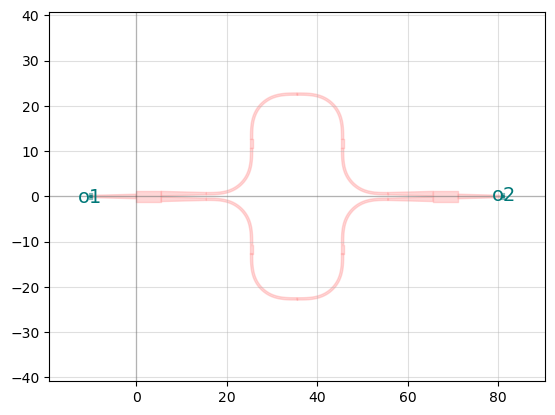

my_component: uid 4dfe1431, ports [], references ['mzi_1'], 0 polygons


In [1]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

# The << is shorthand for c.add_ref()
c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=0)

c


There are there three different relevant amplitudes:
1. The amplitude of the input light:
$
    I_{input} = E_{input}^2
$

2. The amplitudes of the beams after the split
$
    E_{1} = \frac{E_{input}}{\sqrt{2}}, \hspace{2mm} E_{2} = \frac{E_{input}}{\sqrt{2}}
$

3. The amplitude of the recombined light
$
    I_{output} = [\frac{E_{1}+E_{2}}{\sqrt{2}}]^2 = I_{input}
$

```{warning} 
Note that these are not generalized equations. Instead, these describe a balanced interferometer whose branches have not undergone a phase shift.
```

### Quick check
If intensity of the input wave is 0.5 mW, what is the intensity at the output?
<details>
    <summary>Answer</summary>
    0.5 mW 
</details>

## Definitions

It would be helpful to mathematically model the light in our waveguides. We can start to build a model by considering the equation for a plane wave.

$$    
E = E_0 e^{i(\omega t - \beta z)}
$$

Propagation Constant of Light:
$
    \beta = \frac{2 \pi n}{\lambda} 
$

If the equations above describe the propogation of the wave before the light gets split by the MZI, we can represent the two resulting beams as follows.

$$
E_{o1} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{1}L_{1}-\frac{\alpha_{1}}{2}L_{1}}
$$

$$
E_{o2} = \frac{E_{i}}{\sqrt{2}}e^{-i\beta_{2}L_{2}-\frac{\alpha_{2}}{2}L_{2}}
$$

*** As the light travels through the waveguide we can imagine that it will experience some degree of loss. The 'α' term that appeared in the exponents is the loss coefficient. For convenience, the following examples will assume that α = 0, or that there is zero loss in our waveguides.

And finally the intensity of the the recombined light at the end of the MZI can be described like so:

$$
I_{output} = \frac{I_{input}}{4} \lvert E_{o1} + E_{o2} \lvert ^2 
$$

## Analysis of imblanced MZI's

The equation below is the simplified version of the above expressions assuming no difference in the propogation constants of the two different waveguides and no loss.

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\beta \Delta L))
$$

You can install `pip install gdsfactory[full]` for better visualization


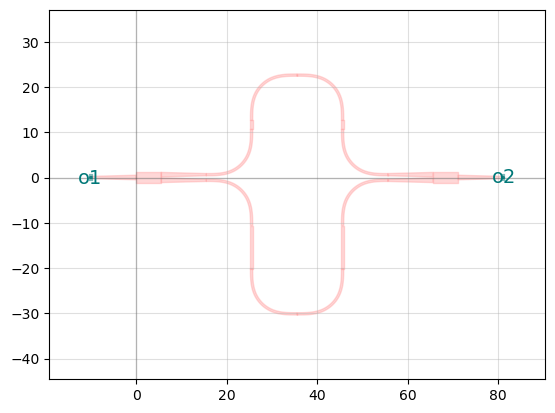

my_component: uid a71ccce9, ports [], references ['mzi_1'], 0 polygons


In [2]:
import gdsfactory as gf

PDK = gf.get_generic_pdk()
PDK.activate()

c = gf.Component("my_component")
mzi = c << gf.components.mzi(delta_length=15)

c


### Quick check
What is the intensity of the output light if the input light had an intensity of 0.75mW, a refractive index through silicon of 3.48 (n=3.48) and a wavelength of 1450 nm. The shorter path has a length of 90µm and the longer path a length of 102µm?
<details>
    <summary>Answer</summary>
    0.491 mW
</details>

## Thermo-optic effect

While a balanced MZI will not experience a phase shift due to a difference in path length, we can introduce a phasae shift by utilizing other methods. The thermo-optic effect describes the effect of heat on the phase of light. By heating up one of the waveguide in the MZI, we can control the phase shift of that waveguide and therefor the intensity of the output. This is a practical way to turn our otherwise static MZI in to a switch that we can control. 

![Image of a thermo-optic switch](https://raw.githubusercontent.com/BYUCamachoLab/Photonics-Bootcamp/main/book/images/Notebook_Images/thermo_optic_switch.png)

Introducing a phase shift in this way will affect the propogation constant 'β' and since we are assuming that the path lengths are equal, we can modify our previous equation like this:

$$
I_{output} = \frac{I_{input}}{2}(1 + cos(\Delta\beta L))
$$

### Quick check
Assume that the lengths of the two paths are 100µm, the light has a wavelength of 1500nm and the ouptput was measured to be 0.9mW. What is the input intensity of the MZI if the heater introduced a 90° phase shift in the top waveguide?
<details>
    <summary>Answer</summary>
    0.0 mW
</details>